# ABS Quarterly Building Activity 8752

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#Headline-charts" data-toc-modified-id="Headline-charts-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Headline charts</a></span><ul class="toc-item"><li><span><a href="#Commencements" data-toc-modified-id="Commencements-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Commencements</a></span></li></ul></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib
import calendar
import datetime

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    get_identifier,
    recalibrate_series,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '8752'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction
abs = get_ABS_meta_and_data(catalogue_id)
if abs is None:
    sys.exit(-1)

Retrieving zip-file from cache ./ABS_CACHE/-statistics-industry-building-and-construction-building-activity-australia-mar-2022-All-Time-Series-workbooks.zip


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

### Headline charts

#### Commencements

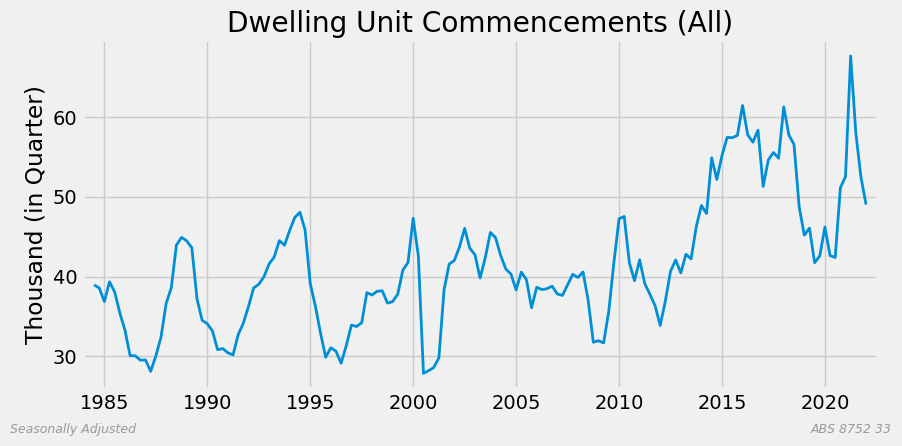

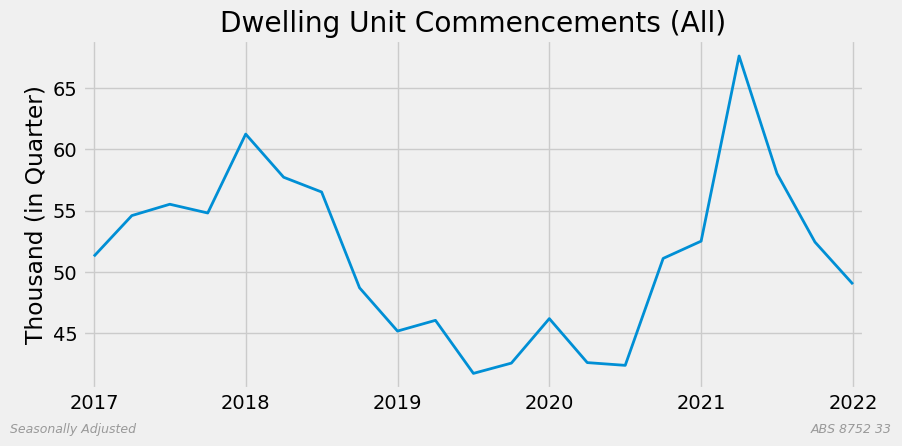

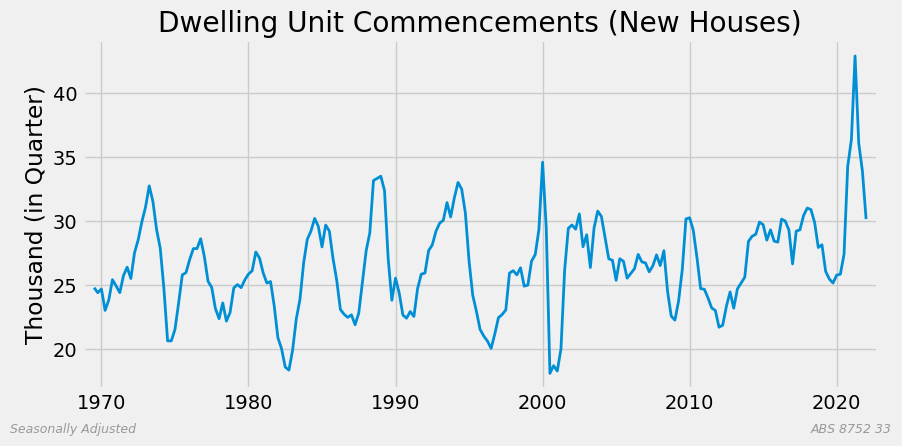

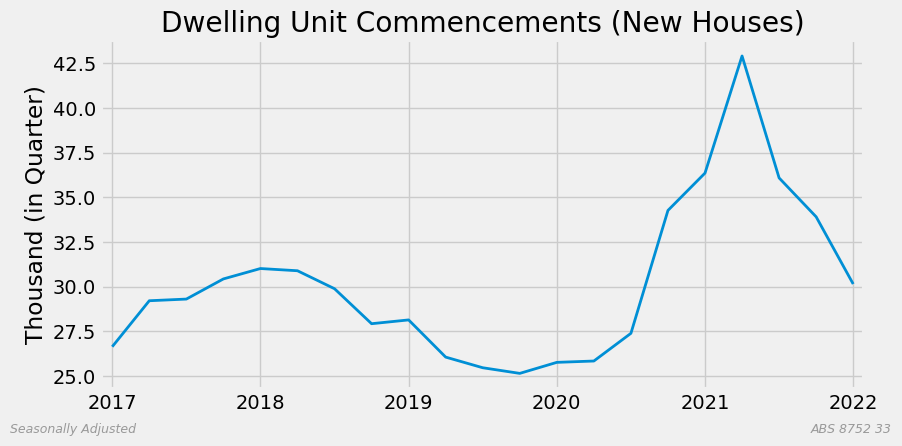

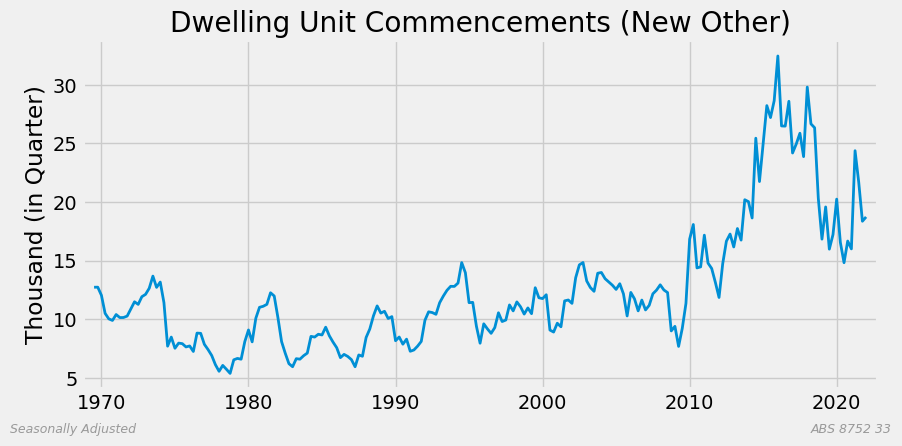

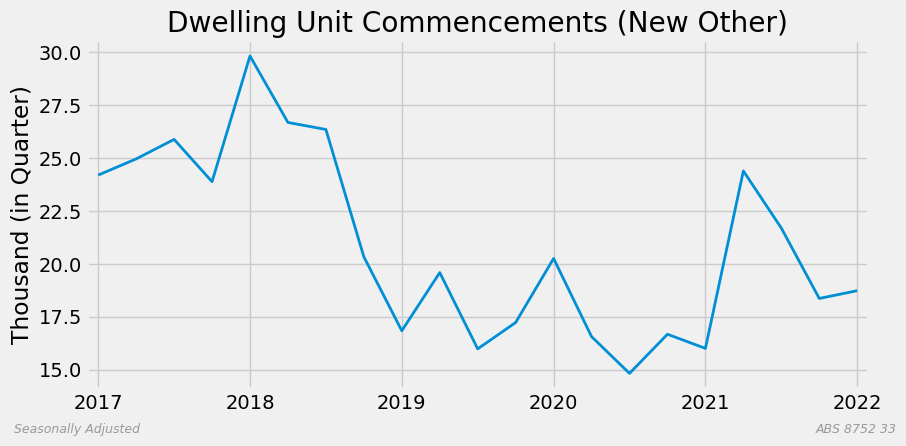

In [7]:
table = '33'
series_type = "Seasonally Adjusted"

total = 'Dwelling units commenced ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;'
houses = 'Dwelling units commenced ;  Total Sectors ;  Houses ;  New ;'
units = 'Dwelling units commenced ;  Total Sectors ;  Total Other Residential ;  New ;'
plot_set = {
    'Dwelling Unit Commencements (All)' : total,
    'Dwelling Unit Commencements (New Houses)': houses,
    'Dwelling Unit Commencements (New Other)': units,    
}

df = abs[table]
for title, element in plot_set.items():

    series, units = get_identifier(meta, element, series_type, table)
    data, units = recalibrate_series(df[series], units)
    
    for start, tag in zip(plot_times, plot_tags):
        plt_data = data[data.index >= start] if start else data
        ax = plt_data.dropna().plot(lw=2)
        finalise_plot(
            ax, title, f'{units} (in Quarter)', 
            tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=series_type,
            show=True,
        )

## Finished

In [6]:
print('Finished')

Finished
